In [149]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import qmc

In [150]:
var_percentile = 0.05
rng_seed = 10
curr_stock_val = 1e6 * np.ones(4)
fixed_leg_rate = 4.2 / 100
one_bee_pee = 0.01 / 100
swap_notional = 100_000_000
start_date = pd.to_datetime("2023-10-30")

## Data Prep ##

In [ ]:
filename = "hist_data_updated.xlsm"

In [151]:
swap_raw = pd.read_excel(filename, sheet_name="SofrCurve")
aapl_raw = pd.read_excel(filename, sheet_name="AAPL").set_index("Date")
msft_raw = pd.read_excel(filename, sheet_name="MSFT").set_index("Date")
f_raw = pd.read_excel(filename, sheet_name="F").set_index("Date")
bac_raw = pd.read_excel(filename, sheet_name="BAC").set_index("Date")

In [152]:
swap_raw.head()

,Tenor,T,2022-10-31 00:00:00,2022-11-01 00:00:00,2022-11-02 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-07 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,...,2023-10-17 00:00:00,2023-10-18 00:00:00,2023-10-19 00:00:00,2023-10-20 00:00:00,2023-10-23 00:00:00,2023-10-24 00:00:00,2023-10-25 00:00:00,2023-10-26 00:00:00,2023-10-27 00:00:00,2023-10-30 00:00:00
0,1D,0.002778,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1,1M,0.083333,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2,2M,0.166667,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265
3,3M,0.250000,0.040536,0.040725,0.040852,0.041154,0.040611,0.041424,0.041406,0.041445,...,0.053666,0.053561,0.053454,0.053323,0.053404,0.053424,0.053490,0.053414,0.053368,0.053476
4,6M,0.500000,0.044577,0.044849,0.044884,0.045281,0.045212,0.045455,0.045334,0.045299,...,0.054078,0.053989,0.053758,0.053546,0.053638,0.053690,0.053749,0.053567,0.053486,0.053612


In [153]:
# clean up swap raw
swap_raw.index = swap_raw["T"]
swap_raw.drop(columns=["T"], inplace=True)
swap_raw.drop(columns=["Tenor"], inplace=True)
swap_raw = swap_raw.T

In [154]:
swap_raw.head()

T,0.002778,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000,3.000000,4.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,25.000000,30.000000,35.000000,40.000000
2022-10-31 00:00:00,0.039191,0.038721,0.038670,0.040536,0.044577,0.046004,0.046449,0.044583,0.042002,0.040318,...,0.037151,0.037057,0.036907,0.036698,0.036433,0.036111,0.034091,0.032350,0.030552,0.028708
2022-11-01 00:00:00,0.039604,0.039023,0.038886,0.040725,0.044849,0.046448,0.046970,0.045022,0.042344,0.040614,...,0.036802,0.036682,0.036511,0.036287,0.036010,0.035678,0.033645,0.031979,0.030238,0.028478
2022-11-02 00:00:00,0.039948,0.039286,0.039100,0.040852,0.044884,0.046580,0.047203,0.045496,0.042749,0.040868,...,0.036855,0.036701,0.036498,0.036248,0.035953,0.035613,0.033627,0.031936,0.030292,0.028608
2022-11-03 00:00:00,0.040389,0.039585,0.039350,0.041154,0.045281,0.047107,0.047894,0.046594,0.043833,0.041825,...,0.037221,0.037069,0.036886,0.036657,0.036372,0.036022,0.033811,0.032134,0.030407,0.028655
2022-11-04 00:00:00,0.045965,0.042343,0.038795,0.040611,0.045212,0.046752,0.047500,0.046097,0.043385,0.041503,...,0.037687,0.037557,0.037380,0.037152,0.036870,0.036534,0.034424,0.032558,0.030723,0.028933


In [155]:
swap_raw_abs_change = swap_raw.diff().dropna()

In [156]:
swap_raw_abs_change.head()

T,0.002778,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000,3.000000,4.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,25.000000,30.000000,35.000000,40.000000
2022-11-01 00:00:00,0.000413,0.000302,0.000216,0.000188,0.000272,0.000444,0.000521,0.000439,0.000342,0.000296,...,-0.000349,-0.000375,-0.000395,-0.000411,-0.000423,-0.000434,-0.000446,-0.000372,-0.000314,-0.000230
2022-11-02 00:00:00,0.000344,0.000262,0.000214,0.000128,0.000035,0.000132,0.000234,0.000474,0.000404,0.000254,...,0.000053,0.000019,-0.000013,-0.000040,-0.000058,-0.000064,-0.000018,-0.000043,0.000054,0.000130
2022-11-03 00:00:00,0.000440,0.000299,0.000250,0.000302,0.000397,0.000527,0.000690,0.001098,0.001085,0.000957,...,0.000366,0.000368,0.000388,0.000409,0.000420,0.000409,0.000184,0.000198,0.000115,0.000047
2022-11-04 00:00:00,0.005576,0.002758,-0.000555,-0.000543,-0.000069,-0.000355,-0.000394,-0.000497,-0.000448,-0.000322,...,0.000466,0.000488,0.000494,0.000495,0.000498,0.000512,0.000613,0.000424,0.000315,0.000278
2022-11-07 00:00:00,-0.005741,-0.003085,0.000665,0.000813,0.000243,0.000437,0.000429,0.000536,0.000499,0.000413,...,0.000431,0.000463,0.000487,0.000504,0.000512,0.000514,0.000498,0.000577,0.000577,0.000562


In [157]:
# clean up swap
aapl_raw.rename(columns={"Adj Close": "aapl_close"}, inplace=True)
msft_raw.rename(columns={"Adj Close": "msft_close"}, inplace=True)
f_raw.rename(columns={"Adj Close": "f_close"}, inplace=True)
bac_raw.rename(columns={"Adj Close": "bac_close"}, inplace=True)
stock_raw = pd.concat([aapl_raw, msft_raw, f_raw, bac_raw], axis=1)
stock_raw = stock_raw

In [158]:
stock_raw.head()

,aapl_close,msft_close,f_close,bac_close
Date,,,,
2022-10-31,152.041122,229.443207,11.974380,34.748581
2022-11-01,149.373917,225.529037,12.001248,34.902847
2022-11-02,143.801514,217.552444,11.696740,34.796783
2022-11-03,137.703613,211.770157,11.875863,34.603954
2022-11-04,137.435455,218.827515,12.099767,35.471703


In [159]:
stock_raw_rel_change = stock_raw.pct_change().dropna()

In [160]:
stock_raw_rel_change.head()

,aapl_close,msft_close,f_close,bac_close
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980


In [161]:
# do we really need other rates if we know its 10y annual?
swap_raw = swap_raw.loc[:, 1:10]
swap_raw_abs_change = swap_raw_abs_change.loc[:, 1:10]

In [162]:
stock_count = len(stock_raw_rel_change.columns)
swap_count = len(swap_raw_abs_change.columns)
risk_factor_count = swap_count + stock_count

In [163]:
# current stock prices
curr_stock_price = stock_raw.loc[start_date]
# get the stock count, i.e. stock weights
stock_weights = curr_stock_val / curr_stock_price.to_numpy()

In [164]:
# current swap zero rate
curr_swap_rate = swap_raw.loc[start_date]
# current swap price - YES THIS IS HORRIBLE, NO I DONT CARE
start_df = pd.DataFrame(curr_swap_rate).T
for x in start_df.columns:
    start_df[x] = np.exp(-start_df[x].astype(float) * (x))
swap_simulated_disc = start_df.to_numpy()
for i in range(len(swap_simulated_disc)):
    temp_pv_fix = sum(swap_simulated_disc[i]) * fixed_leg_rate
    temp_pv_float = 1 - swap_simulated_disc[i][-1]
    curr_swap_price = temp_pv_float - temp_pv_fix
curr_swap_price = curr_swap_price * swap_notional

In [165]:
print(f"current stock values are {curr_stock_val}")
print(f"current swap value is {curr_swap_price}")

current stock values are [1000000. 1000000. 1000000. 1000000.]
current swap value is 2442901.9998463197


## Moddeling the Joint Distribution of the Daily Risk Factor Changes ##
* For each risk factor, specify how you want to model their changes. As I suggested, one
way is to model the absolute daily changes in the zero rate risk factors and model the
daily relative returns of the stock prices.
* Once the above is specified, follow the approach of each VaR model (parametric/Monte
Carlo/historical) to model the joint distribution of the daily risk factor changes.

For each risk factor, you would need to use the 1-year historical data provided to compute their
daily changes over the 1-year historical period. Using the historical daily changes of the risk
factors, one can then determine the joint distribution of 1-day risk factor changes under each of
the 3 VaR models

* Parametric VaR. The 1-day risk factor changes are assumed to be multivariate-normally
distributed. One can simply estimate the means and covariance matrix of the multivariate
normal distribution using the sample means and convariance matrix calculated from the
historical daily changes.
* Monte Carlo VaR. The 1-day risk factor changes are also assumed to be
multivariate-normally distributed. Hence, one simply follow the same appproach as the
parametric VaR to estimate the means and covariance matrix of the multivariate normal
distribution.
* Historical VaR. The joint distribution of the 1-day risk factor changes is simply given by
the empirical distribution of the 1-year historical sample of daily risk factor changes.
Dr. Tony Wong 4 / 21


## Swap PV01 ##


Begin with calculating the PV01, we will find the price of the option at T = 0

In [166]:
start_df = pd.DataFrame(curr_swap_rate)
start_df["disc_factor"] = np.exp(-start_df.index * start_df[start_df.columns[0]])

In [167]:
def get_pv_fix(df_with_discfactor, disc_factor_colname, the_fixed_rate):
    total_df = 0
    for x in df_with_discfactor.index:
        # print(x)
        if x in range(1, 11):
            total_df += df_with_discfactor.loc[x, disc_factor_colname]
    # print(f"for {disc_factor_colname} sum is {total_df}")
    return total_df * the_fixed_rate

In [168]:
def get_pv_float(df_with_discfactor, disc_factor_colname):
    return 1 - df_with_discfactor.loc[10.0, disc_factor_colname]

we tickle each of the zero rates by 1bp

In [169]:
start_df_tickled = start_df.copy()

In [170]:
start_df_tickled.drop(columns=["disc_factor"], inplace=True)
tickled_pv = []

In [171]:
# this is highly inneficient but it works so stop complaining
for tenor in start_df_tickled.index:
    # add one bee pee
    colname = f"tickled{tenor}"
    colname_disc = f"disc_tickled{tenor}"
    start_df_tickled[colname] = start_df_tickled[start_df_tickled.columns[0]]
    start_df_tickled.loc[tenor, colname] = (
        start_df_tickled.loc[tenor, colname] + one_bee_pee
    )
    start_df_tickled[colname_disc] = np.exp(
        -start_df_tickled.index * start_df_tickled[colname]
    )
    temp_pv_fix = get_pv_fix(start_df_tickled, colname_disc, fixed_leg_rate)
    temp_pv_float = get_pv_float(start_df_tickled, colname_disc)
    temp_pv_total = temp_pv_float - temp_pv_fix
    tickled_pv.append(temp_pv_total)
    start_df_tickled.drop(columns=[colname], inplace=True)
tickled_pv = np.array(tickled_pv)

In [172]:
tickled_pv = tickled_pv * swap_notional
tickled_pv

array([2443300.60052302, 2443665.17952428, 2444001.29995438,
       2444308.65520298, 2444587.474945  , 2444839.10545498,
       2445065.2334407 , 2445267.32260306, 2445446.7767528 ,
       2509961.52610256])

In [173]:
pv01 = tickled_pv - curr_swap_price
pv01_notional = pv01 * 10_000
pv01_notional

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08])

## Combined Parametric ? ##

In [174]:
port_sensitivity = []
port_sensitivity.extend(pv01_notional)
port_sensitivity.extend(curr_stock_val)

In [175]:
# I THINK PROF GOT MISSING DATA
combined_risk_factor = pd.concat(
    [swap_raw_abs_change, stock_raw_rel_change], axis=1
).dropna(axis=0)

In [176]:
combined_mean = combined_risk_factor.mean()
combined_var = combined_risk_factor.cov()
print(combined_mean)

1.0           0.000018
2.0           0.000007
3.0           0.000007
4.0           0.000012
5.0           0.000015
6.0           0.000017
7.0           0.000020
8.0           0.000021
9.0           0.000023
10.0          0.000024
aapl_close    0.000461
msft_close    0.001606
f_close      -0.000738
bac_close    -0.001181
dtype: float64


In [177]:
# my instinct was to use np.dot, but this is easier to read & understand
port_mean = np.matmul(port_sensitivity, combined_mean)
port_var = np.matmul(np.matmul(port_sensitivity, combined_var), port_sensitivity)
z_value = norm.ppf(var_percentile)
var_port = port_mean + z_value * np.sqrt(port_var)
var_port

-936889.2562434216

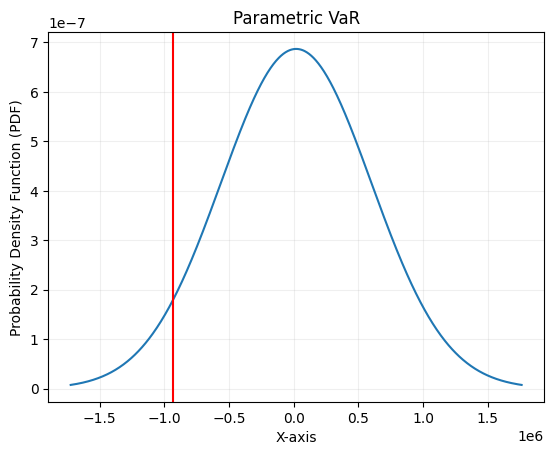

In [178]:
# Generate data points for the normal distribution
mean = port_mean
std_dev = np.sqrt(port_var)
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution
plt.plot(x, y, label=f"Mean={mean}, Std Dev={std_dev}")
plt.title("Parametric VaR")
plt.xlabel("X-axis")
plt.ylabel("Probability Density Function (PDF)")
plt.axvline(var_port, color="red")
plt.grid(alpha=0.2)
plt.show()

## MONTE CARLO - FULL REEVAL ##

In [179]:
# whatever at this point
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html
def random_sobol_points(dimensions, power):
    simulation = qmc.Sobol(d=dimensions, scramble=False)
    simulation = simulation.random_base2(m=power)
    simulation = np.delete(simulation, 0, axis=0)
    return simulation


def inverse_cdf(values, my_mean, my_std):
    return norm.ppf(values, loc=my_mean, scale=my_std)

1. Calculate the Base Scenario Portfolio Value

In [180]:
# does this mean we just combine pnl for the whole protfolio - NO
# 1. calculate the base scenario portfolio value
print(curr_stock_val)
print(curr_swap_price)

[1000000. 1000000. 1000000. 1000000.]
2442901.9998463197


2. Joint distribution of the risk factor changes

In [181]:
combined_cholesky = np.linalg.cholesky(combined_risk_factor.corr().to_numpy())
combined_rand_points = random_sobol_points(risk_factor_count, 14)
rand_normal = inverse_cdf(
    combined_rand_points, combined_risk_factor.mean(), combined_risk_factor.std()
)
print(combined_rand_points.shape)

(16383, 14)


In [182]:
# ALRIGHT ALRIGHT FINE I FOLLOW UR SHEETS AAAAA
correlated_std_normals_combined = np.matmul(combined_cholesky, rand_normal.T).T
df_correlated_std_normals_combined = pd.DataFrame(correlated_std_normals_combined)
# SPLIT THE SIMULATED VALUES !
df_simu_for_swaps = df_correlated_std_normals_combined.loc[:, 0:9]
df_simu_for_stocks = df_correlated_std_normals_combined.loc[:, 10:13]

3. calculate the porvolio value Pi and eventually use it to calculate PnL

In [183]:
stock_simulated_returns = (df_simu_for_stocks + 1).to_numpy()
stock_simulated_prices = stock_simulated_returns * curr_stock_price.to_numpy()
stock_simulated_port = stock_weights * stock_simulated_prices
stock_simulated_pnl = stock_simulated_port - 1_000_000
df_stock_simulated_pnl = pd.DataFrame(stock_simulated_pnl)

In [184]:
# swap only monte carlo
df_swap_simulated_rates = pd.DataFrame(
    curr_swap_rate.to_numpy() + df_simu_for_swaps.to_numpy(),
    columns=curr_swap_rate.index,
)
for x in df_swap_simulated_rates.columns:
    df_swap_simulated_rates[x] = np.exp(-df_swap_simulated_rates[x].astype(float) * (x))
# ok this becomes disc factor but fuck
swap_simulated_disc = df_swap_simulated_rates.to_numpy()
swap_simulated_pv = []
for i in range(len(swap_simulated_disc)):
    temp_pv_fix = sum(swap_simulated_disc[i]) * fixed_leg_rate
    temp_pv_float = 1 - swap_simulated_disc[i][-1]
    temp_pv_total = temp_pv_float - temp_pv_fix
    swap_simulated_pv.append(temp_pv_total)
swap_simulated_pv = np.array(swap_simulated_pv) * swap_notional
df_swap_simulated_pnl = pd.DataFrame(swap_simulated_pv - curr_swap_price)

4. Distribution of portfolio PnL

In [185]:
df_mc_reval_simulated_pnl = pd.concat(
    [df_stock_simulated_pnl, df_swap_simulated_pnl], axis=1
)
df_mc_reval_simulated_pnl = df_mc_reval_simulated_pnl.sum(axis=1)
port_var_mc_fullreval = df_mc_reval_simulated_pnl.quantile(var_percentile)

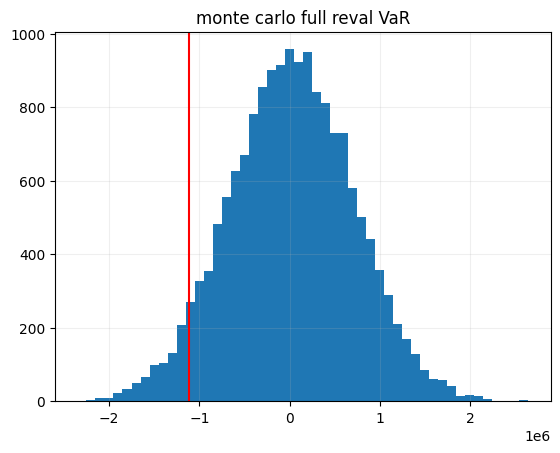

In [186]:
plt.title("monte carlo full reval VaR")
plt.hist(df_mc_reval_simulated_pnl, 50)
plt.axvline(port_var_mc_fullreval, color="red")
plt.grid(alpha=0.2)

## MONTE CARLO - RISK BASED ##

In [187]:
port_val_mc_riskbased = np.matmul(
    port_sensitivity, df_correlated_std_normals_combined.to_numpy().T
)
port_val_mc_riskbased = pd.Series(port_val_mc_riskbased)
port_var_mc_riskbased = port_val_mc_riskbased.quantile(var_percentile)
print(port_var_mc_riskbased)

-1109662.4582711295


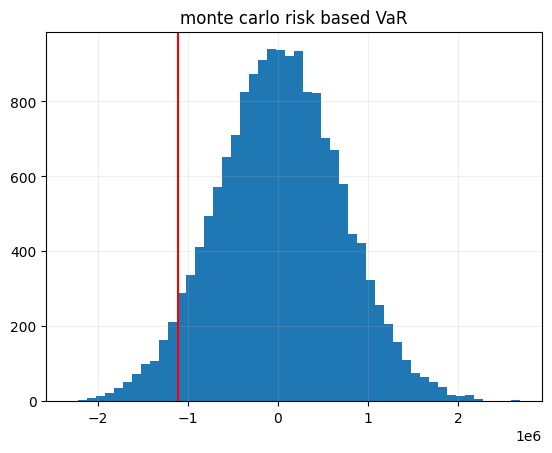

In [188]:
plt.title("monte carlo risk based VaR")
plt.hist(port_val_mc_riskbased, 50)
plt.axvline(port_var_mc_riskbased, color="red")
plt.grid(alpha=0.2)

## Historical - FULL RE EVALUATION ##

1. Calculate the Base Scenario Portfolio Value

In [189]:
print(curr_stock_val)
print(curr_swap_price)

[1000000. 1000000. 1000000. 1000000.]
2442901.9998463197


2. Joint distribution of the risk factor changes

In [190]:
# SPLIT THE SIMULATED VALUES !
df_hist_for_swaps = swap_raw_abs_change
df_hist_for_stocks = stock_raw_rel_change

3. calculate the porvolio value Pi and eventually use it to calculate PnL

In [191]:
stock_historical_returns = (df_hist_for_stocks + 1).to_numpy()
stock_historical_prices = stock_historical_returns * curr_stock_price.to_numpy()
stock_historical_port = stock_weights * stock_historical_prices
stock_historical_pnl = stock_historical_port - 1_000_000
df_stock_historical_pnl = pd.DataFrame(stock_historical_pnl)
df_stock_historical_pnl

,0,1,2,3
0,-17542.655335,-17059.428567,2243.790493,4439.490637
1,-37305.060428,-35368.363675,-25373.027872,-3038.835199
2,-42404.984693,-26578.818853,15313.925077,-5541.575496
3,-1947.356312,33325.554932,18853.703516,25076.585179
4,3902.093532,29269.692159,14063.576596,5979.865134
...,...,...,...,...
245,2543.334713,3674.240518,-7839.614216,-3910.865120
246,-13491.581744,30678.046863,13169.354821,3140.968115
247,-24605.546085,-37514.323638,-16464.393007,22309.172066
248,7969.294457,5855.609927,-122466.946714,-36370.607896


In [192]:
# swap only monte carlo
df_swap_historical_rates = pd.DataFrame(
    curr_swap_rate.to_numpy() + df_hist_for_swaps.to_numpy(),
    columns=curr_swap_rate.index,
)
for x in df_swap_historical_rates.columns:
    df_swap_historical_rates[x] = np.exp(
        -df_swap_historical_rates[x].astype(float) * (x)
    )
# ok this becomes disc factor but fuck
swap_historical_disc = df_swap_historical_rates.to_numpy()
swap_historical_pv = []
for i in range(len(swap_historical_disc)):
    temp_pv_fix = sum(swap_historical_disc[i]) * fixed_leg_rate
    temp_pv_float = 1 - swap_historical_disc[i][-1]
    temp_pv_total = temp_pv_float - temp_pv_fix
    swap_historical_pv.append(temp_pv_total)
swap_historical_pv = np.array(swap_historical_pv) * swap_notional
df_swap_historical_pnl = pd.DataFrame(swap_historical_pv - curr_swap_price)

4. Distribution of portfolio PnL

In [193]:
df_historical_reval_pnl = pd.concat(
    [df_stock_historical_pnl, df_swap_historical_pnl], axis=1
)
df_historical_reval_pnl = df_historical_reval_pnl.sum(axis=1)
port_var_hist_fullreval = df_historical_reval_pnl.quantile(var_percentile)

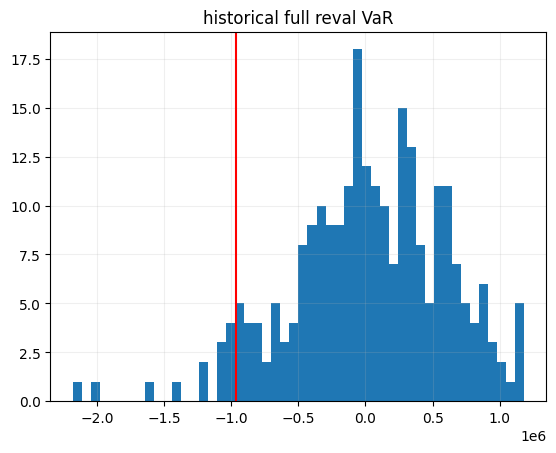

In [194]:
plt.title("historical full reval VaR")
plt.hist(df_historical_reval_pnl, 50)
plt.axvline(port_var_hist_fullreval, color="red")
plt.grid(alpha=0.2)

## HISTORICAL - RISK BASED ##

In [195]:
port_val_hist_riskbased = np.matmul(port_sensitivity, combined_risk_factor.to_numpy().T)
port_val_hist_riskbased = pd.Series(port_val_hist_riskbased)
port_var_hist_risk_based = port_val_hist_riskbased.quantile(var_percentile)
print(port_var_hist_risk_based)

-980180.011697411


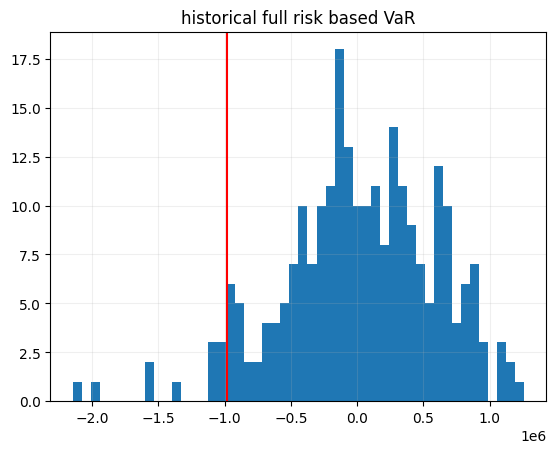

In [196]:
plt.title("historical full risk based VaR")
plt.hist(port_val_hist_riskbased, 50)
plt.axvline(port_var_hist_risk_based, color="red")
plt.grid(alpha=0.2)

## CONCLUSION ! ##

In [197]:
print(f"parametric VAR {var_port}")
print(f"monte carlo VAR full reval {port_var_mc_fullreval}")
print(f"monte carlo VAR risk based {port_var_mc_riskbased}")
print(f"historical VAR full reval {port_var_hist_fullreval}")
print(f"historical VAR risk based {port_var_hist_risk_based}")

parametric VAR -936889.2562434216
monte carlo VAR full reval -1117690.4994785693
monte carlo VAR risk based -1109662.4582711295
historical VAR full reval -966173.2175561559
historical VAR risk based -980180.011697411
